# Feature engineering
### Stellar Classification Dataset - SDSS17
https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS\
alpha = Right Ascension angle (at J2000 epoch)\
delta = Declination angle (at J2000 epoch)\
u = Ultraviolet filter in the photometric system\
g = Green filter in the photometric system\
r = Red filter in the photometric system\
i = Near Infrared filter in the photometric system\
z = Infrared filter in the photometric system\
run_ID = Run Number used to identify the specific scan\
rereun_ID = Rerun Number to specify how the image was processed\
cam_col = Camera column to identify the scanline within the run\
field_ID = Field number to identify each field\
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)\
class = object class (galaxy, star or quasar object)\
redshift = redshift value based on the increase in wavelength\
plate = plate ID, identifies each plate in SDSS\
MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken\
fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation\

#### Citation
fedesoriano. (January 2022). Stellar Classification Dataset - SDSS17. Retrieved [Date Retrieved] from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17.

Acknowledgements
The data released by the SDSS is under public domain. Its taken from the current data release RD17.

More information about the license: http://www.sdss.org/science/image-gallery/

### Wczytanie potrzebnych elementów i wstępna obróbka danych

Wczytanie bibliotek

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import sklearn 
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Kod z https://stackoverflow.com/a/49199019 generujący requiments.txt
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]
            
        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]
            
        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for i in range(len(requirements)):
    print(f'{requirements[i][0]}=={requirements[i][1]}')

imblearn==0.0
matplotlib==3.7.2
numpy==1.24.3
pandas==2.0.3
scikit-learn==1.2.2
seaborn==0.12.2


Wczytanie i korekta ramki danych

In [3]:
# Wczytanie danych
df_original = pd.read_csv("..\\dane\\star_classification.csv")
development_unit_df, test_sample_df = train_test_split(df_original, test_size=0.3, random_state=42)

# Usuwanie kolumn, które są skorelowane z innymi ze współczynnikiem 1
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'rerun_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'obj_ID']
development_unit_df = development_unit_df.loc[:, development_unit_df.columns != 'plate']
# Usuwanie błędnej obserwacji
development_unit_df = development_unit_df[development_unit_df['u'] > 0]

development_unit_df.head()

,alpha,delta,u,g,r,i,z,run_ID,cam_col,field_ID,spec_obj_ID,class,redshift,MJD,fiber_ID
76513,130.932167,4.313411,20.13070,18.37146,17.49792,17.06977,16.77949,3015,3,112,1.337614e+18,GALAXY,0.155863,52650,165
60406,225.429599,33.172083,19.86315,18.93886,18.59344,18.46922,18.40977,3900,5,594,3.304619e+18,STAR,-0.000529,54652,374
27322,219.173525,55.511740,19.84785,17.60157,16.71511,16.41555,16.25413,3225,4,74,3.711097e+18,STAR,-0.000261,54909,475
53699,178.735461,36.044139,17.83635,16.47576,15.82407,15.45751,15.18434,4552,6,67,2.367855e+18,GALAXY,0.068444,53467,317
65412,192.807458,18.727770,24.27039,22.60266,20.47710,19.45898,19.08250,5314,1,105,6.596788e+18,GALAXY,0.540778,56065,510


### Używane funkcje

In [19]:
def standard_distribution_info(variable_name, shareX):
    fig, ax = plt.subplots(4, 1, sharex=shareX, figsize=(10, 5))
    sns.histplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.histplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.histplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.histplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()

def standard_boxplot_info(variable_name, show_text):
    fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 5))
    sns.boxplot(data=df, x=variable_name, color='#17becf', ax=ax[0]).set(title='All classes')
    sns.boxplot(data=df[df['class']=='GALAXY'], x=variable_name, color='#1f77b4', ax=ax[1]).set(title='GALAXY')
    sns.boxplot(data=df[df['class']=='QSO'], x=variable_name, color='#ff7f0e', ax=ax[2]).set(title='QSO')
    sns.boxplot(data=df[df['class']=='STAR'], x=variable_name, color='#2ca02c', ax=ax[3]).set(title='STAR')
    fig.tight_layout(pad=0.0)
    fig.show()
    if (show_text):
        boxplot_info(variable_name)
    
def boxplot_info(variable_name):
    # outliery są znajdywane za pomocą metody 1.5IQR
    print('All classes:')
    selected_df = df[variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('GALAXY:')
    selected_df = df[df['class']=='GALAXY'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('QSO:')
    selected_df = df[df['class']=='QSO'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    print('STAR:')
    selected_df = df[df['class']=='STAR'][variable_name]
    print('mediana = %s' %np.median(selected_df))
    print('średnia = %s' %np.mean(selected_df))
    Q1 = np.percentile(selected_df, 25)
    Q3 = np.percentile(selected_df, 75)
    IQR = Q3-Q1
    print('Q1 = %s' %Q1,'Q3 = %s' %Q3)
    print('outlier_lower_bound = %s' %(Q1-(1.5*IQR)))
    print('outlier_upper_bound = %s' %(Q3+(1.5*IQR)))
    print('outlier_count = %s' %selected_df[(selected_df < Q1-(1.5*IQR)) | (selected_df > Q3+(1.5*IQR))].count())
    
def standard_correlation_visualisation(variable_name, limit, show_text):
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[:5], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[5:10], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[10:15], hue='class')
    sns.pairplot(df.head(limit), y_vars=variable_name, x_vars=df.columns.values[15:18], hue='class')
    plt.show()
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    df_correlation[variable_name].plot.bar(color='#17becf', ylim=(-1, 1), ax=ax[0, 0]).set(title='All classes correlations') 
    df_correlation_GALAXY[variable_name].plot.bar(color='#1f77b4', ylim=(-1, 1), ax=ax[0, 1]).set(title='GALAXY correlations')
    df_correlation_QSO[variable_name].plot.bar(color='#ff7f0e', ylim=(-1, 1), ax=ax[1, 0]).set(title='QSO correlations')
    df_correlation_STAR[variable_name].plot.bar(color='#2ca02c', ylim=(-1, 1), ax=ax[1, 1]).set(title='STAR correlations')
    ax[0, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[0, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    ax[1, 0].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-')
    ax[1, 1].axhline(y = 0, color = 'black', linewidth = 0.5, linestyle = '-') 
    fig.tight_layout(pad=5.0)
    fig.show()
    if (show_text):
        print('korelacja:')
        print('all_classes: \n%s' %df_correlation.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('GALAXY: \n%s' %df_correlation_GALAXY.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('QSO: \n%s' %df_correlation_QSO.sort_values(by=[variable_name], ascending=False)[variable_name])
        print('STAR: \n%s' %df_correlation_STAR.sort_values(by=[variable_name], ascending=False)[variable_name])
        
def test_models(df):
    # Podział na dane do trenowania i dane do walidacji
    X_train, X_test, y_train, y_test = train_test_split(
        df.drop('class', axis=1), df['class'], test_size=0.2, random_state=42)

    print('Dokładności modeli:')
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("LogisticRegression", accuracy)
    
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("KNeighborsClassifier:", accuracy)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("RandomForestClassifier:", accuracy)
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("DecisionTreeClassifier:", accuracy)
    
#     model = svm.SVC(kernel='linear')
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("SVC:", accuracy)
    
#     model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=42)
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print("MLPClassifier:", accuracy)


# Inżynieria cech

### Pierwsza iteracja

In [5]:
df = development_unit_df.copy()

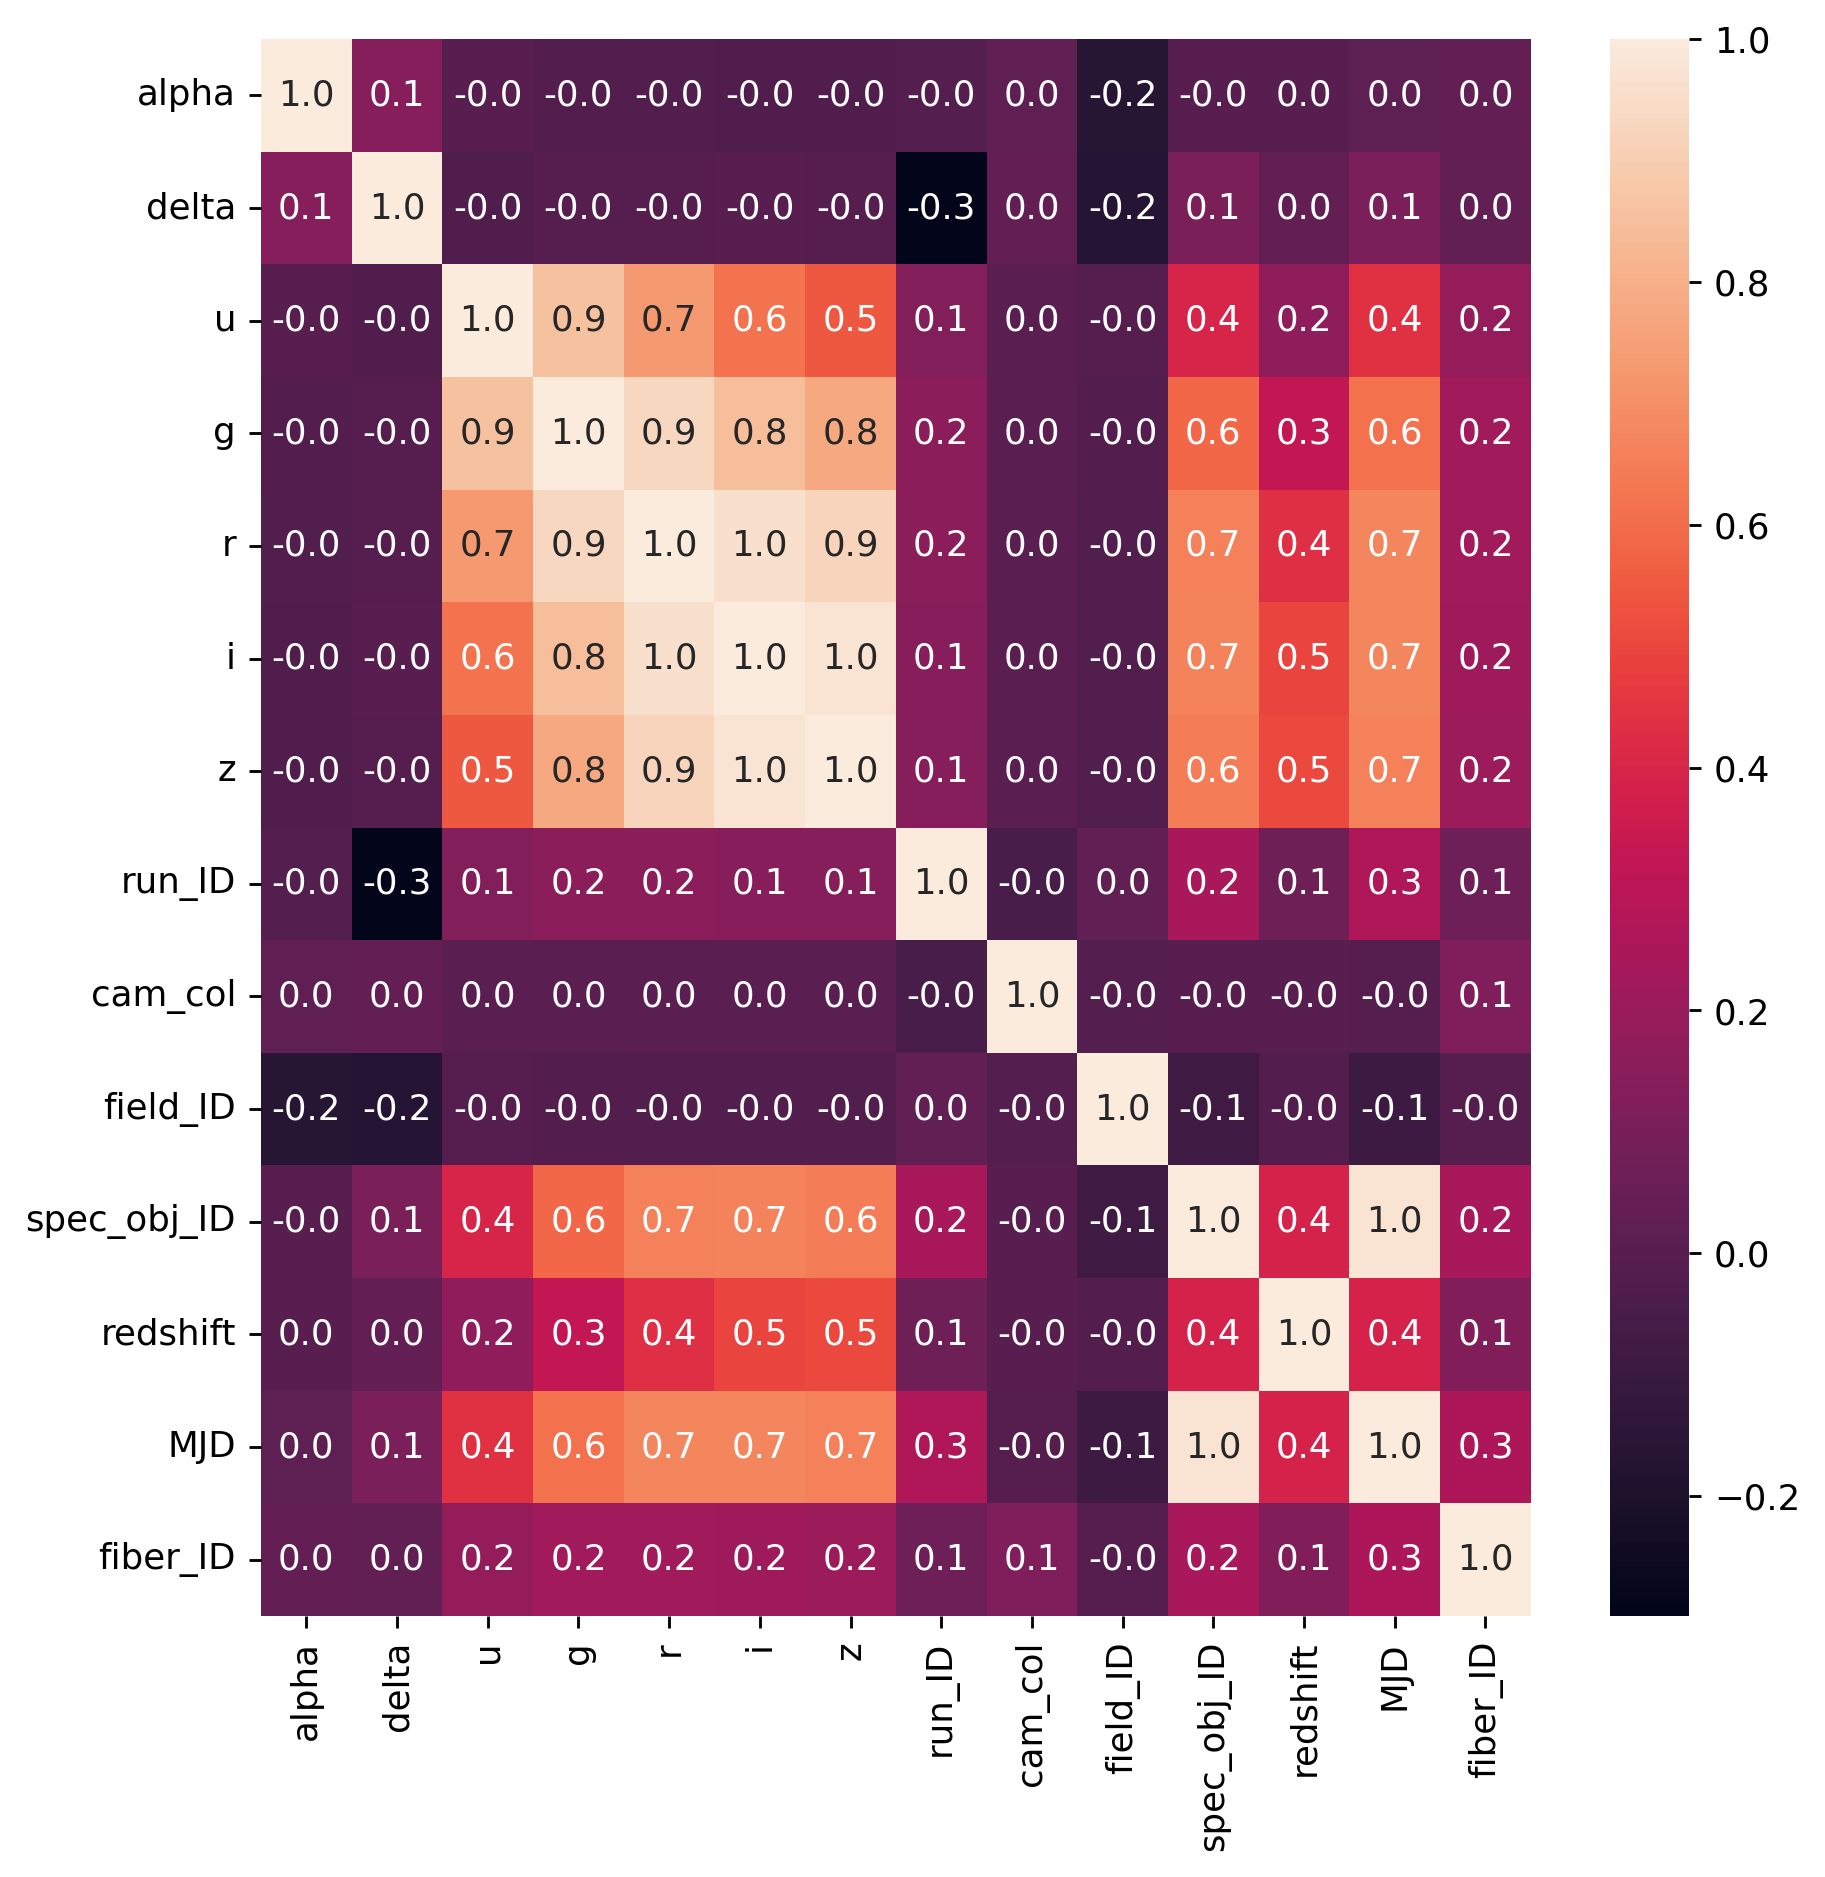

In [6]:
## jeszcze raz macierz korelacji -> widzimy, że usunęliśmy najbardziej skorelowane kolumny
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

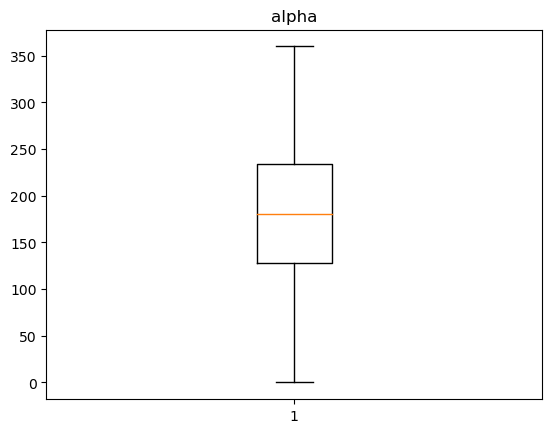

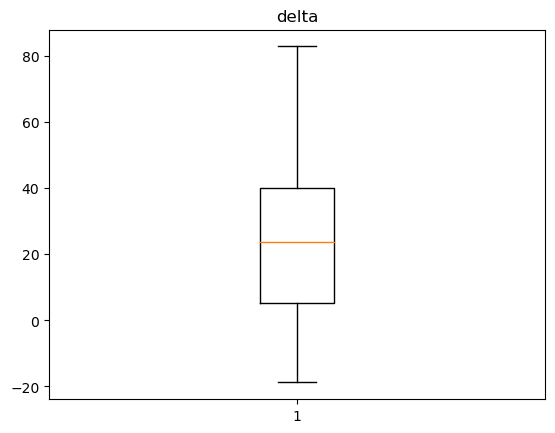

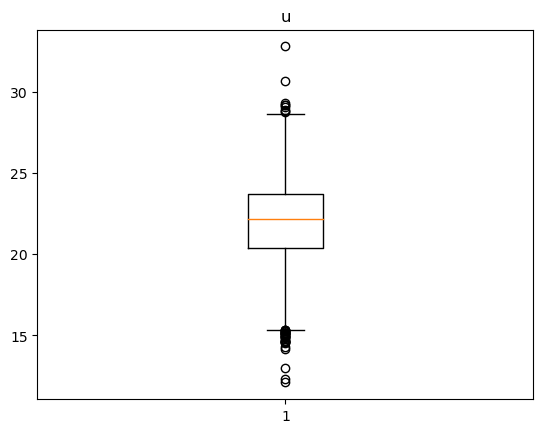

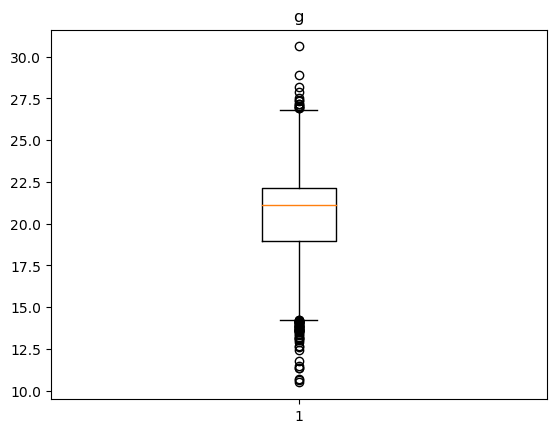

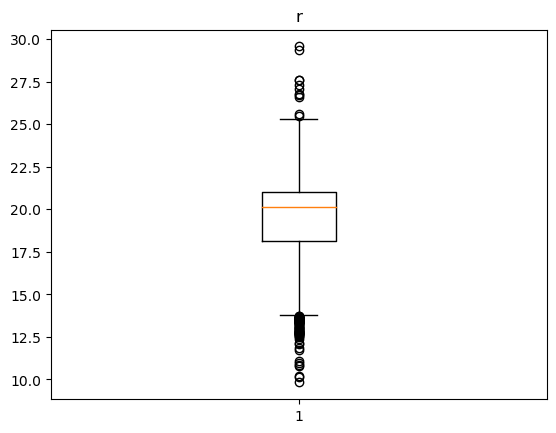

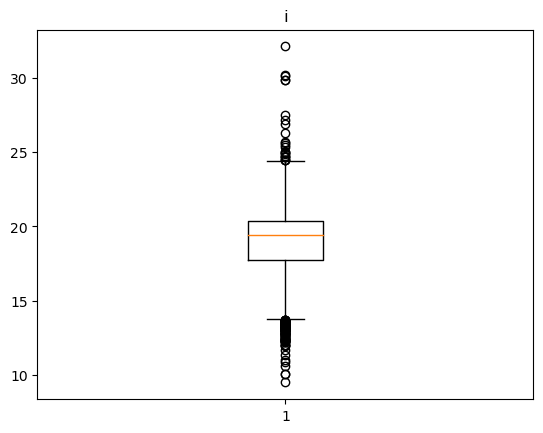

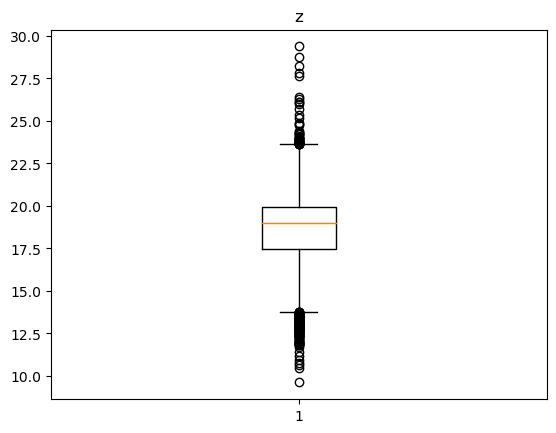

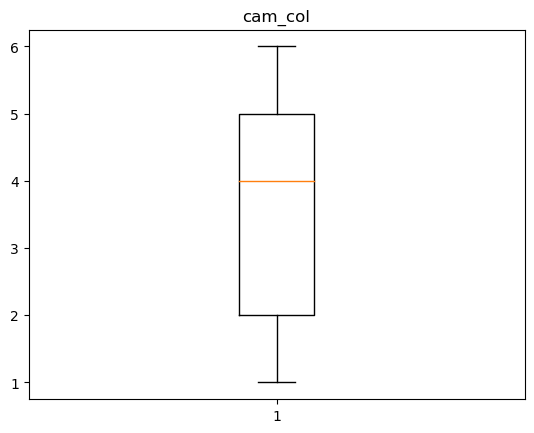

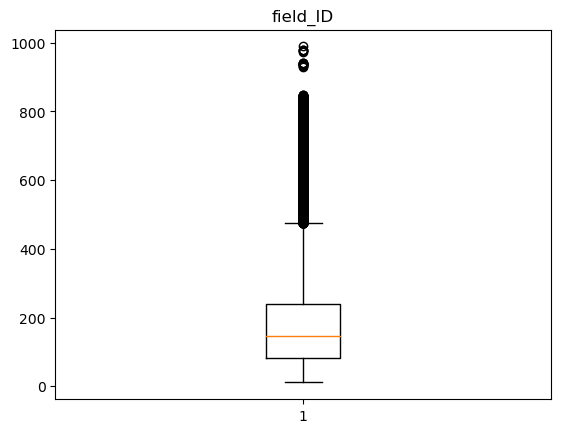

In [7]:
## usuwanie OUTLIERS: zobaczmy, dla których zmiennych wystąpują wartości odstające
for i in range(10):
    if i != 7:
        plt.boxplot(df.iloc[:, i])
        plt.title(df.columns[i])
        plt.show()

In [8]:
### przyjrzyjmy się outlierom w kolumnach 'u', 'r' jeszcze raz:
columns_to_be_checked = ['r', 'u']

for i in range(len(columns_to_be_checked)):
    column = df[columns_to_be_checked[i]]
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)

    IQR = Q3 - Q1

    outliers = (column < (Q1 - 1.5 * IQR)) | (column > (Q3 + 1.5 * IQR))

    outliers_count = outliers.sum()

    outliers_percentage = outliers.mean() * 100
    df = df[~outliers]
    print(outliers_count)
    print("Ilość outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_count)
    print("Procentowy udział outlierów dla kolumny ", columns_to_be_checked[i] , ": ", outliers_percentage)
    
    ## usuńmy outliery dla u i r: stanowią tylko 0.13% i 0.03% wszystkich wierszy

92
Ilość outlierów dla kolumny  r :  92
Procentowy udział outlierów dla kolumny  r :  0.13142857142857142
16
Ilość outlierów dla kolumny  u :  16
Procentowy udział outlierów dla kolumny  u :  0.02288722320764433


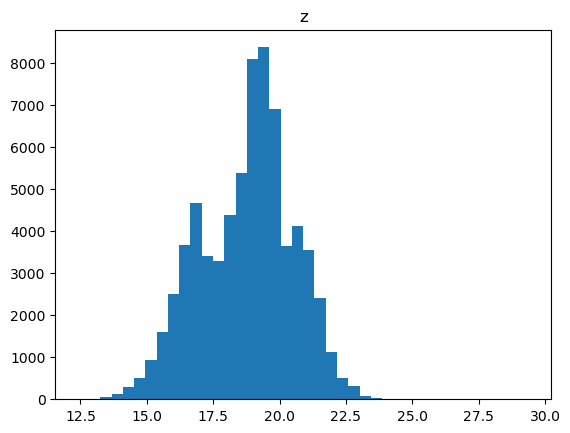

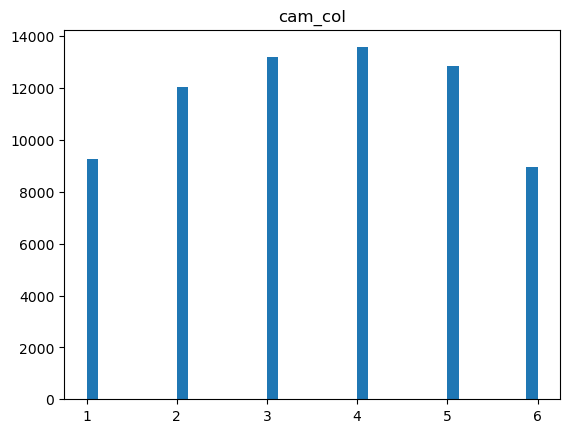

In [9]:
### spójrzmy jeszcze na dwie pozostałe kolumny z outlierami:

plt.hist(df.iloc[:, 6], bins = 40)
plt.title(df.columns[6])
plt.show()

plt.hist(df.iloc[:, 8], bins = 40)
plt.title(df.columns[8])
plt.show()

# zmienne redshift oraz filed_ID mają rozkład wykładniczy -> chyba nie usuwamy outlierów ???

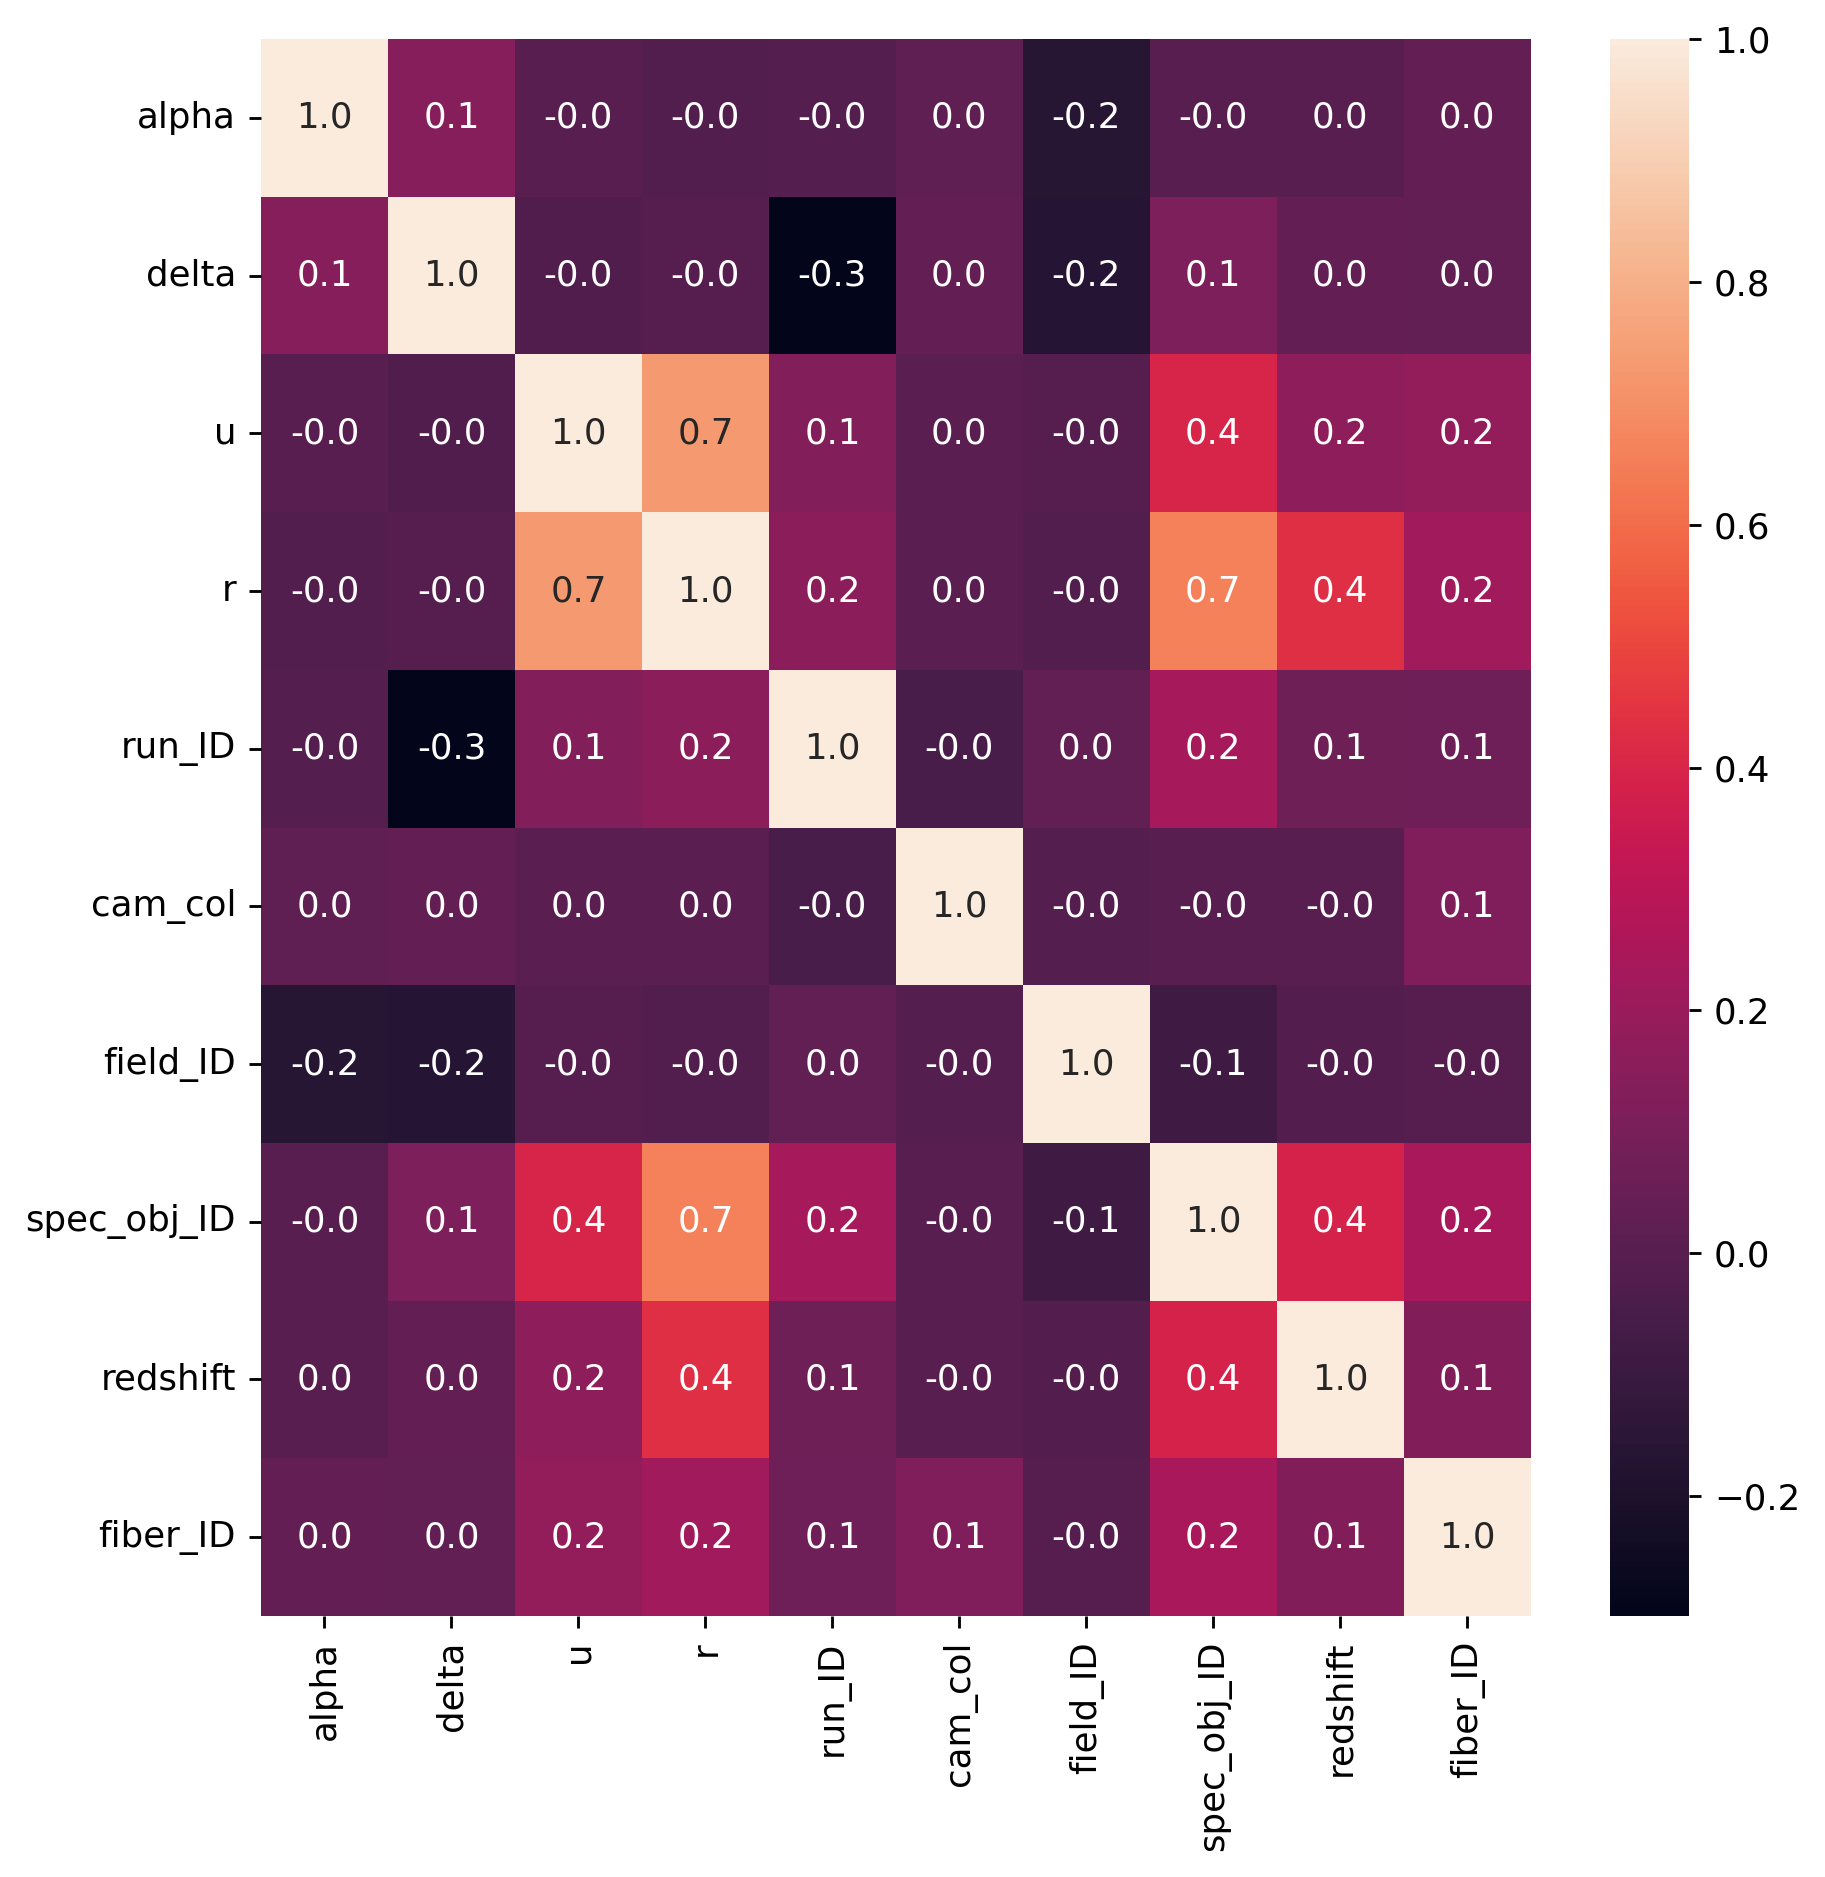

In [10]:
df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

In [11]:
# Tworzenie kopii ramki danych
# df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn
# df = df.drop(['i', 'g', 'z', 'MJD'], axis = 1)

# Korekta outlierów

# Zrównoważenie
y = df['class']
df = df.drop('class', axis=1)
smote = SMOTE()
df, y_resampled = smote.fit_resample(df, y)
df['class'] = pd.DataFrame(y_resampled)

# Normalizacja
columns_to_standardize = ['run_ID', 'fiber_ID', 'alpha', 'delta', 'redshift', 'spec_obj_ID', 'cam_col', 'u', 'r', 'field_ID']
df[columns_to_standardize] = MinMaxScaler().fit_transform(df[columns_to_standardize])

# Standaryzacja
columns_to_normalize = ['u']
df[columns_to_normalize] = StandardScaler().fit_transform(df[columns_to_normalize])

# Informacje o ramce danych
df.describe()

,alpha,delta,u,r,run_ID,cam_col,field_ID,spec_obj_ID,redshift,fiber_ID
count,124593.000000,124593.000000,1.245930e+05,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000,124593.000000
mean,0.492009,0.427543,-2.427159e-16,0.514568,0.540551,0.481189,0.174779,0.414994,0.103383,0.449366
std,0.269555,0.195356,1.000004e+00,0.152018,0.241965,0.305767,0.143483,0.245157,0.126210,0.260814
min,0.000000,0.000000,-3.107514e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.348066,0.237718,-7.055003e-01,0.407579,0.381969,0.200000,0.074642,0.201859,0.001429,0.235235
50%,0.500392,0.431574,-1.343994e-02,0.554164,0.499938,0.400000,0.138037,0.399061,0.063335,0.432432
75%,0.653064,0.589497,6.646336e-01,0.629266,0.662859,0.800000,0.229039,0.605245,0.173189,0.637638
max,1.000000,1.000000,3.322409e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Testowanie

In [12]:
test_models(df)

Dokładności modeli:
LogisticRegression 0.9295316826517918
KNeighborsClassifier: 0.8508768409647257
RandomForestClassifier: 0.9786508286849392
DecisionTreeClassifier: 0.9649263614109715


Wnioski
- przy zamianie outlierow z kolumn field_ID, redshift lub ich usunięciu, dokładności przykładowych 
modeli spadają do około 40 - 50 %
- normalizacja przed standaryzacją daje gorsze wyniki, bez standaryzacji zmiennej u też są gorsze wyniki
- można się jeszcze zastanowić nad usunięciem zmiennej 'r' ponieważ ma ona korelację z zmienną 'u' równą 0.73 
(co jest dosyć sporo) + bez tej zmiennej model ma porównywalną precyzyjność

## Macierz korelacji dla ramki bez modefiakcji

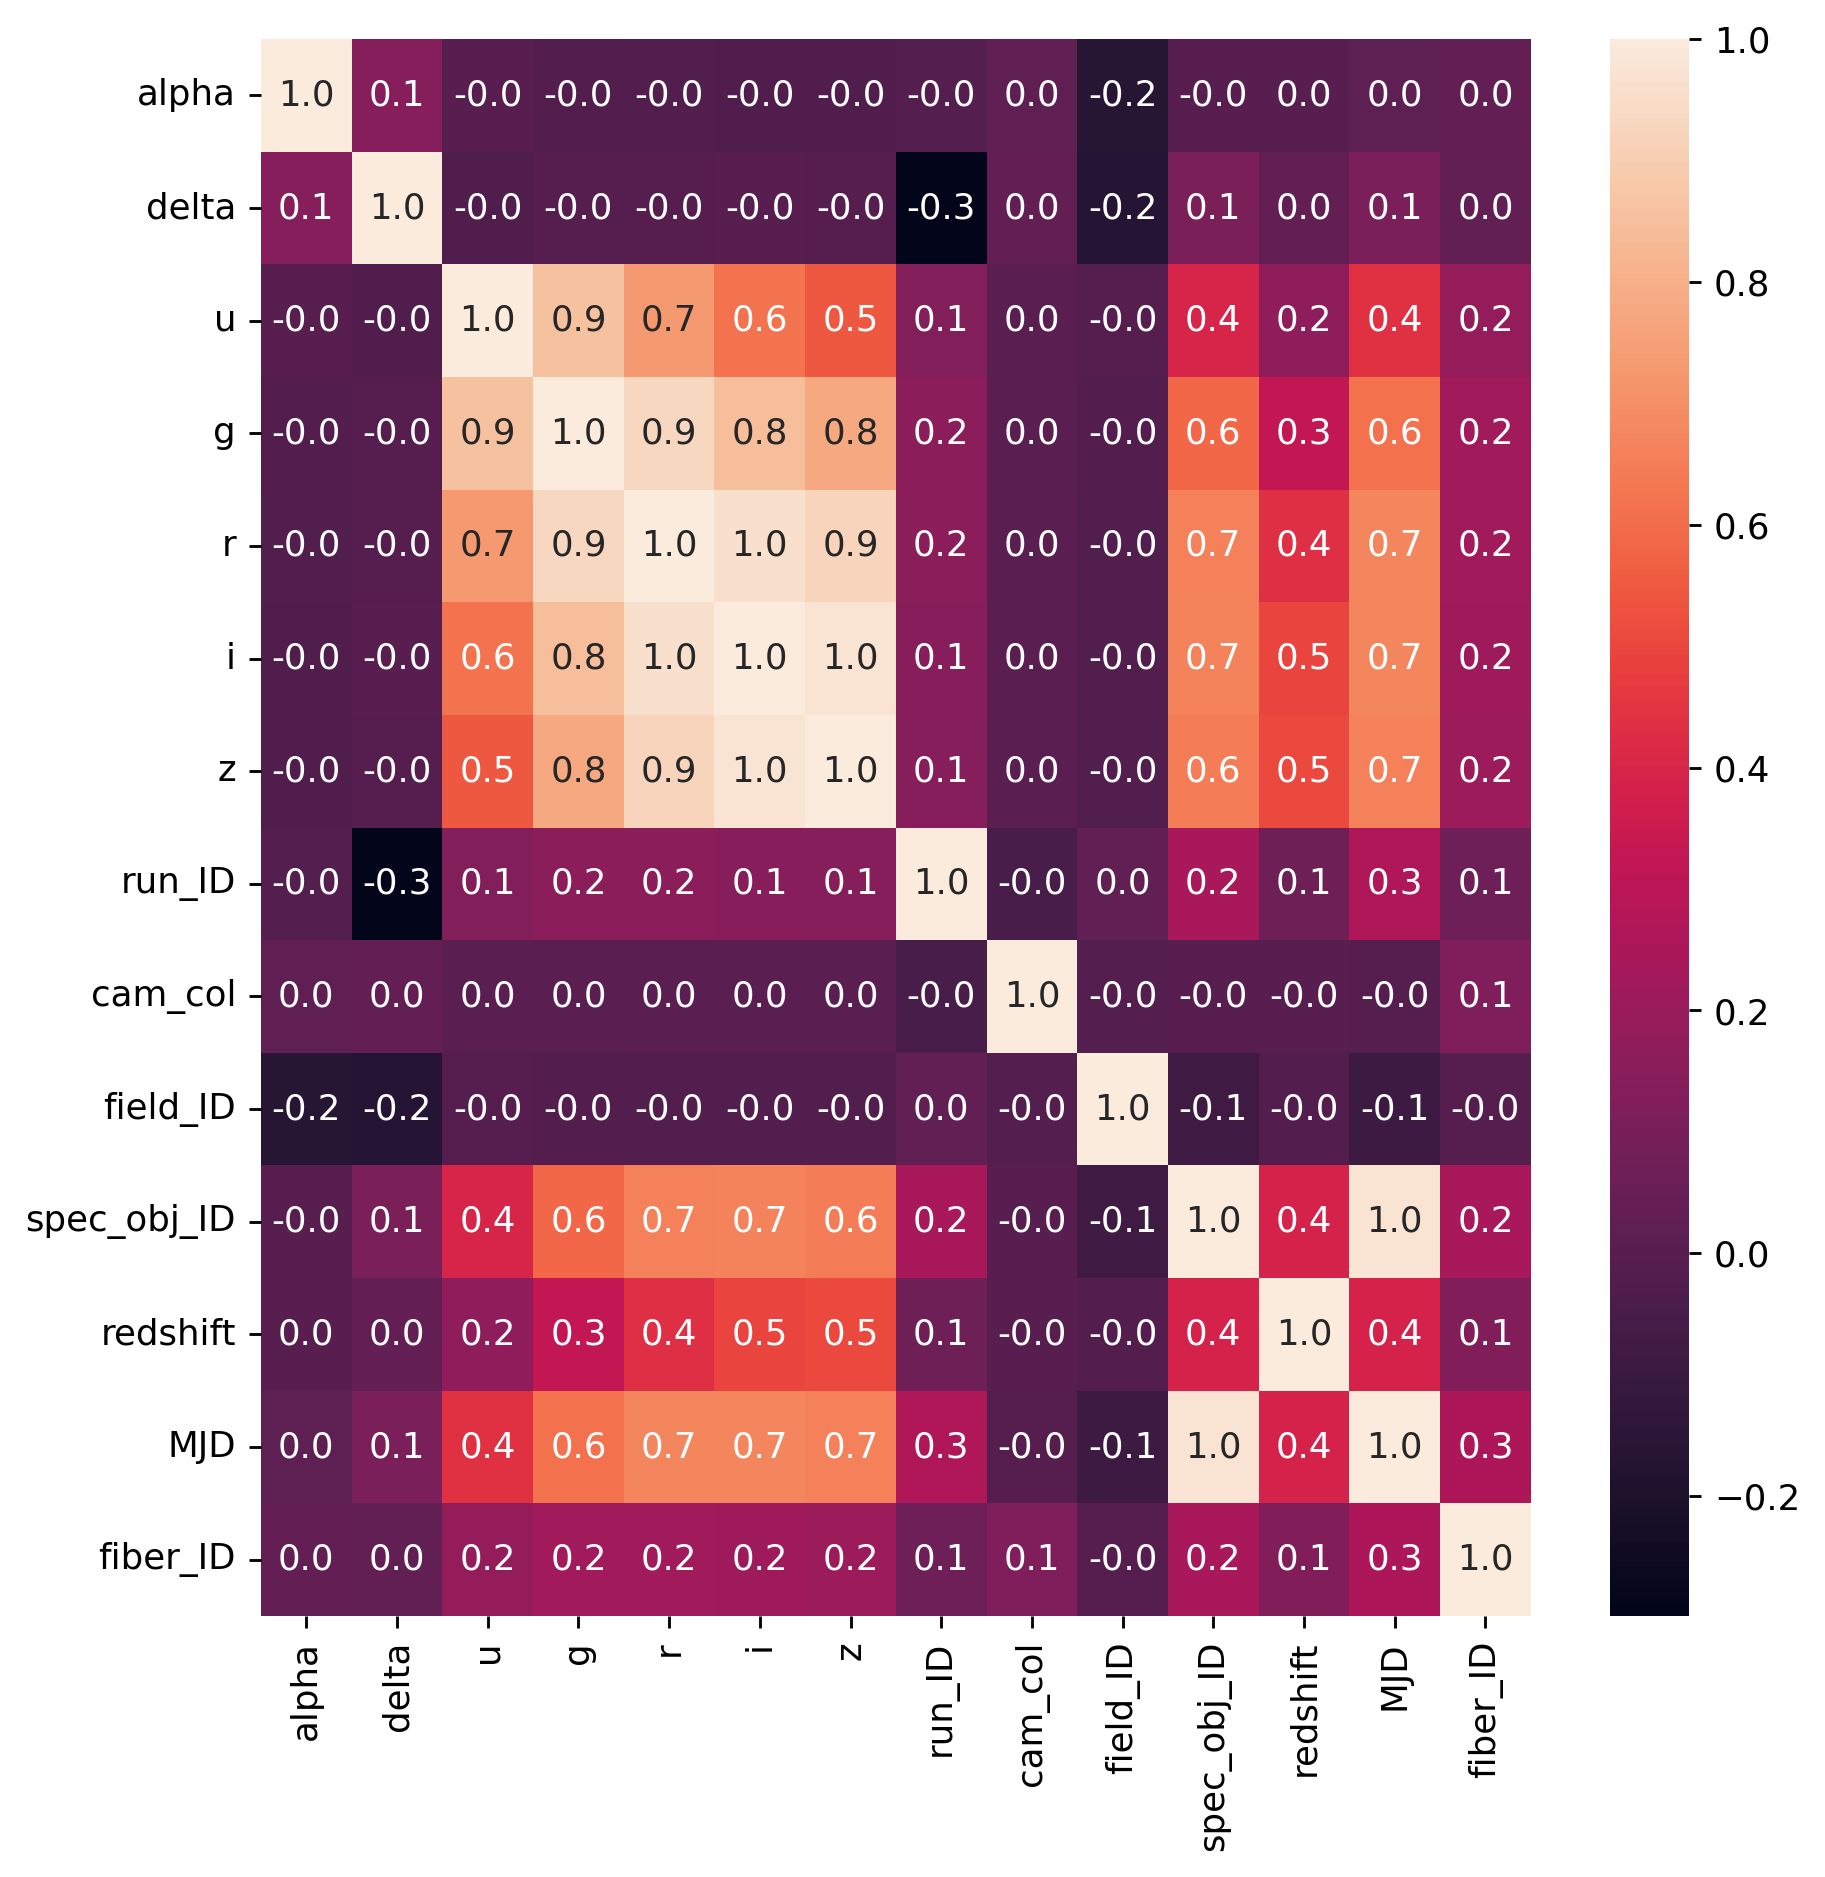

In [13]:
df = development_unit_df.copy()
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

## Bez modefikacji

In [14]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn

# Korekta outlierów

# Zrównoważenie

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

# Testowanie
test_models(df)

Dokładności modeli:
LogisticRegression 0.5947857142857143
KNeighborsClassifier: 0.7056428571428571
RandomForestClassifier: 0.9778571428571429
DecisionTreeClassifier: 0.9639285714285715


## Usunięcie silnie skorelowanych kolumn

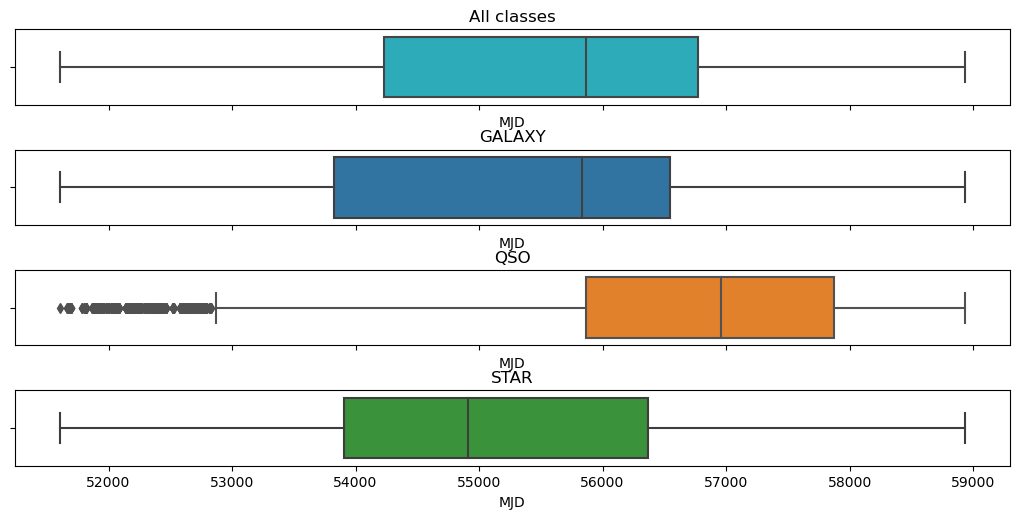

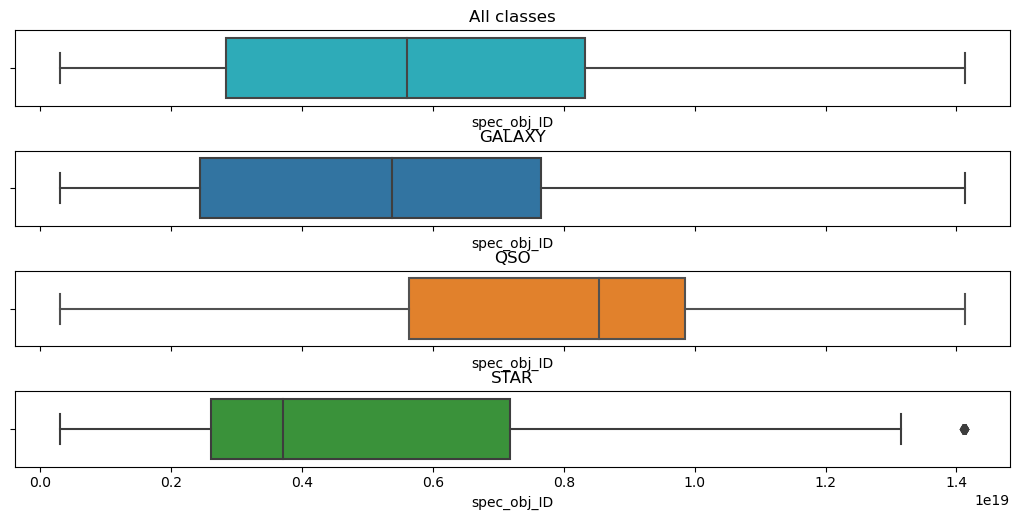

In [21]:
df = development_unit_df.copy()
standard_boxplot_info('MJD', False)
standard_boxplot_info('spec_obj_ID', False)

In [22]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)

# Korekta outlierów

# Zrównoważenie

# Normalizacja

# Standaryzacja

# Informacje o ramce danych

test_models(df)

Dokładności modeli:
LogisticRegression 0.5947857142857143
KNeighborsClassifier: 0.7056428571428571
RandomForestClassifier: 0.975
DecisionTreeClassifier: 0.9555714285714285


## Usunięcie silnie skorelowanych cech + normalizacja/standaryzacja

In [23]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech

# Usuwanie kolumn
df = df.drop(['MJD'], axis = 1)
df = df.drop(['g', 'r', 'i', 'z'], axis = 1)

# Korekta outlierów

# Zrównoważenie

# Normalizacja
columns_to_normalize = ['alpha', 'run_ID', 'cam_col', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['u', 'delta', 'field_ID', 'redshift']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Informacje o ramce danych

test_models(df)

Dokładności modeli:
LogisticRegression 0.5947857142857143
KNeighborsClassifier: 0.7056428571428571
RandomForestClassifier: 0.9748571428571429
DecisionTreeClassifier: 0.9555


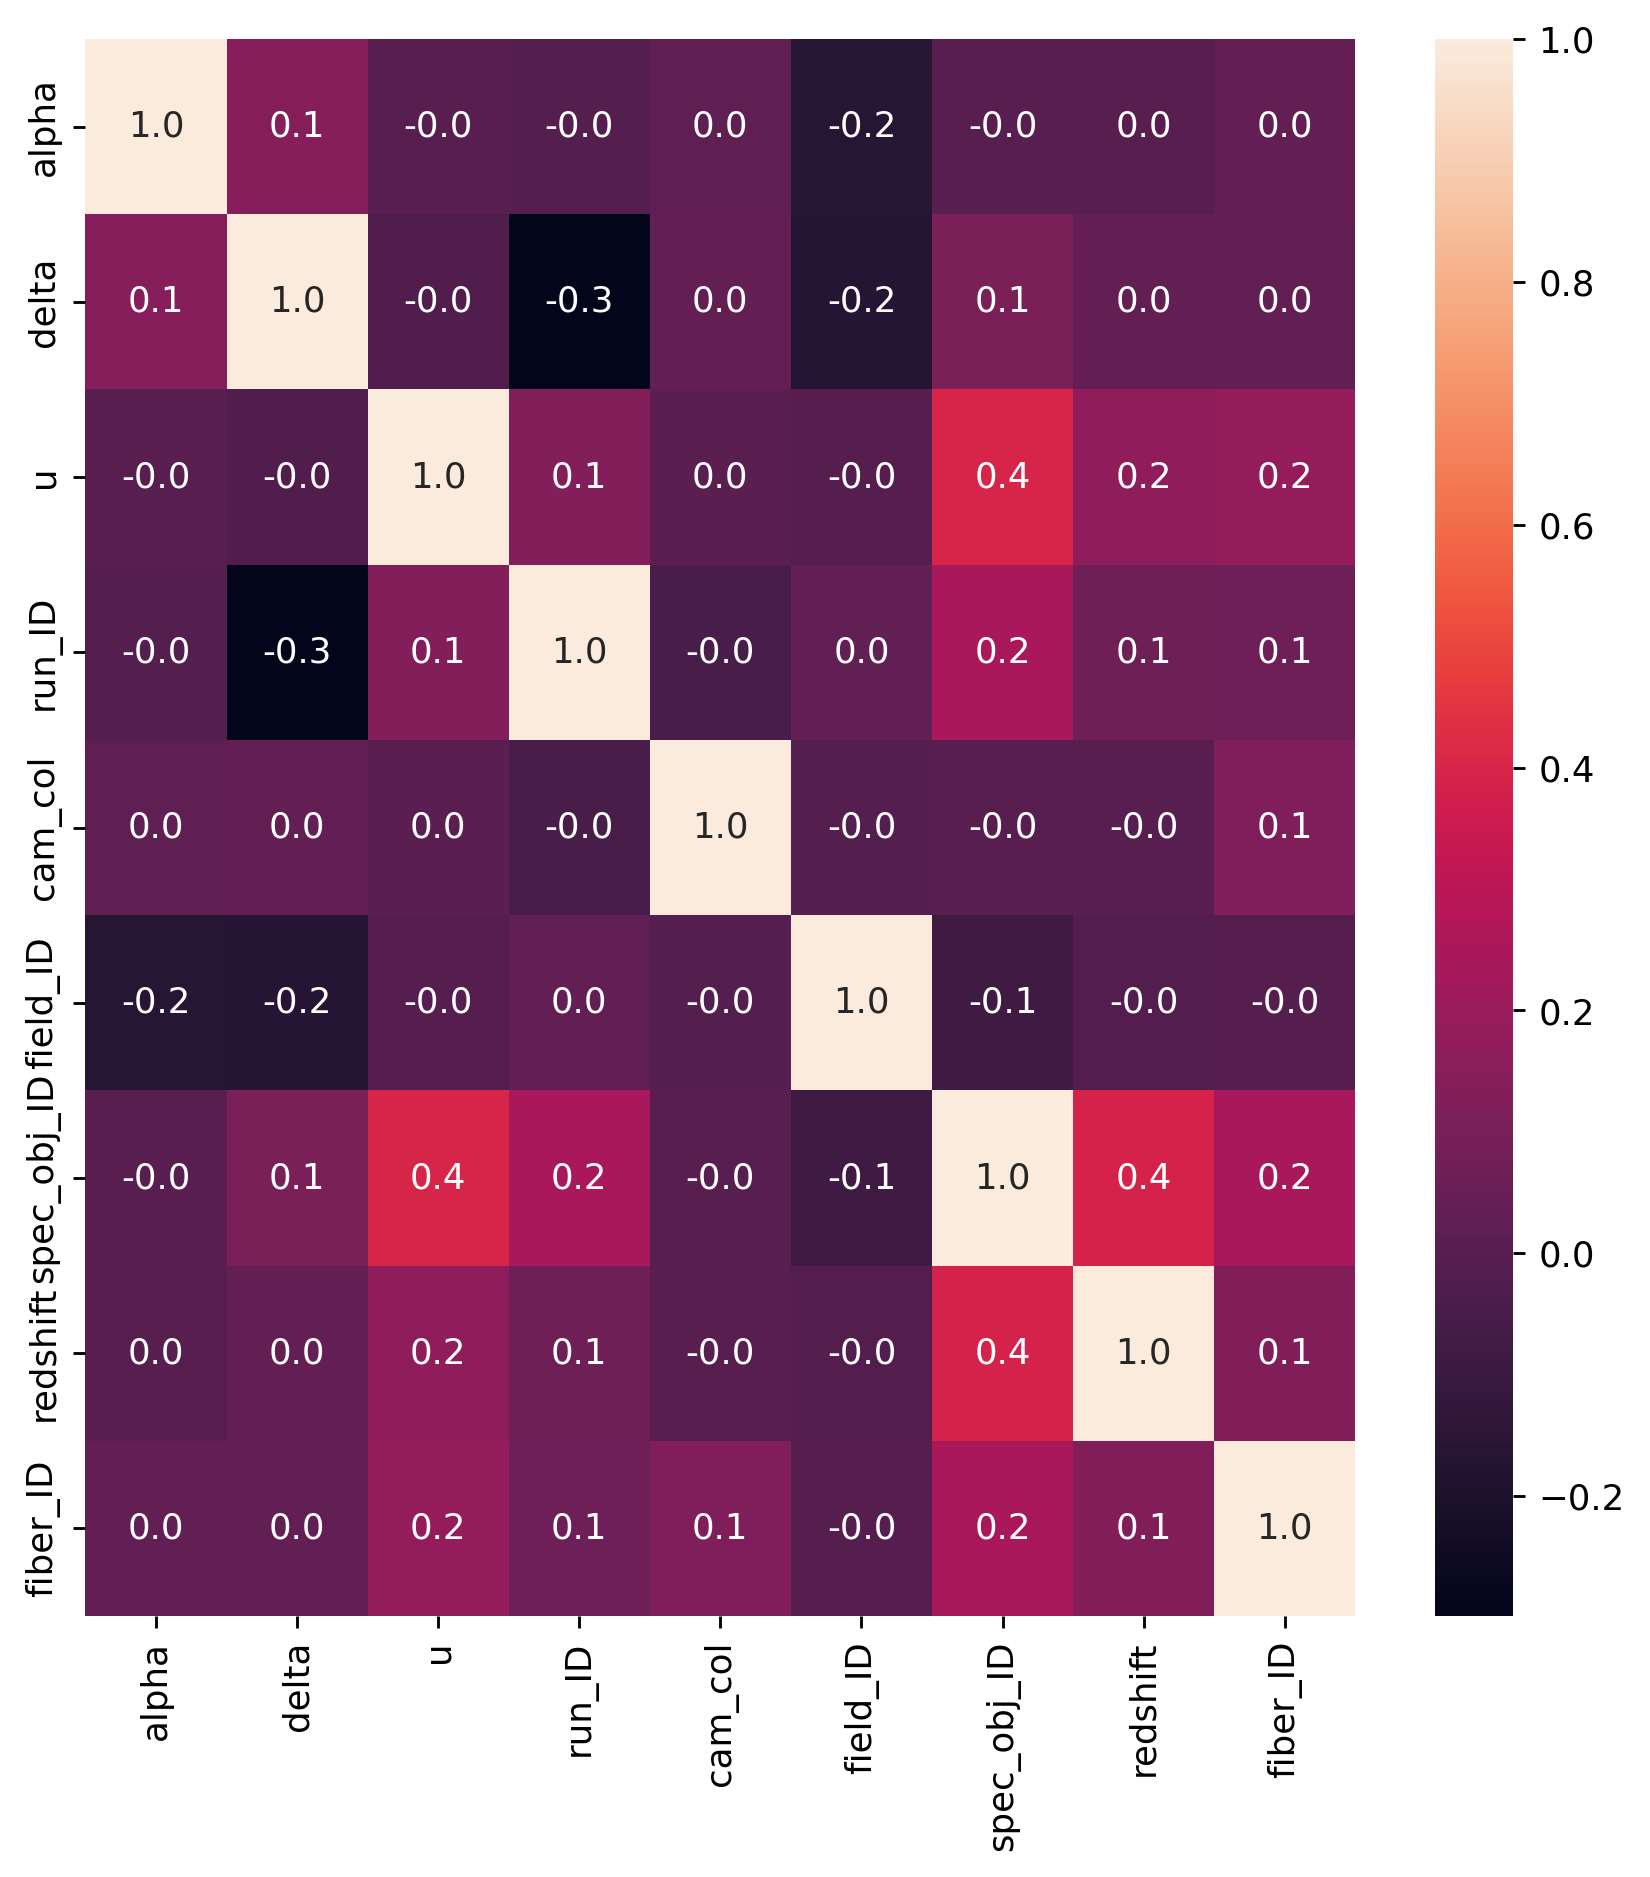

In [24]:
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

### Dodawanie cech podczerwonych itp. WIP

Inżynieria cech

In [111]:
# Tworzenie kopii ramki danych
df = development_unit_df.copy()

# Modefikowanie cech
# df['u+g'] = df[['u', 'g']].sum(axis=1)
# df['r+i+z'] = df[['r', 'i', 'z']].sum(axis=1)
df['u+g+r+i+z'] = df[['u', 'g', 'r', 'i', 'z']].sum(axis=1)

# Usuwanie kolumn
df = df.drop(['spec_obj_ID', 'MJD'], axis = 1)
df = df.drop(['u', 'g', 'r', 'i', 'z'], axis = 1)

# Korekta outlierów

# Zrównoważenie

# Normalizacja
columns_to_normalize = ['alpha', 'run_ID', 'cam_col', 'fiber_ID']
df[columns_to_normalize] = MinMaxScaler().fit_transform(df[columns_to_normalize])

# Standaryzacja
columns_to_standardize = ['delta', 'field_ID', 'redshift']
df[columns_to_standardize] = StandardScaler().fit_transform(df[columns_to_standardize])


# Informacje o ramce danych
# df.describe()

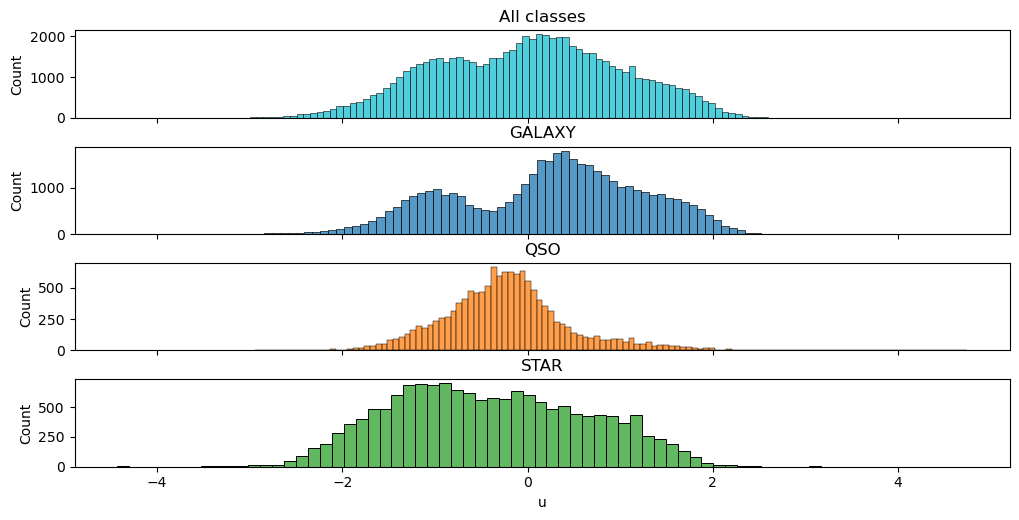

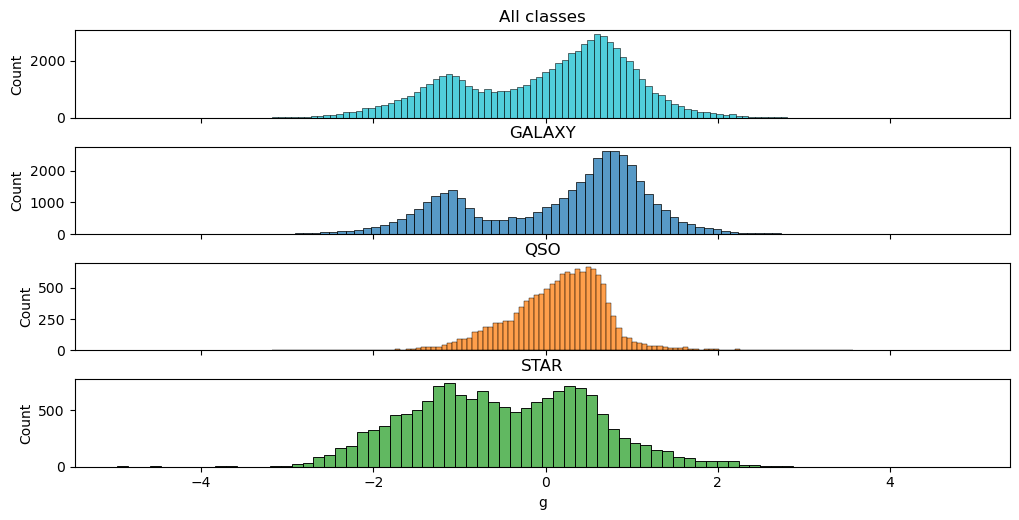

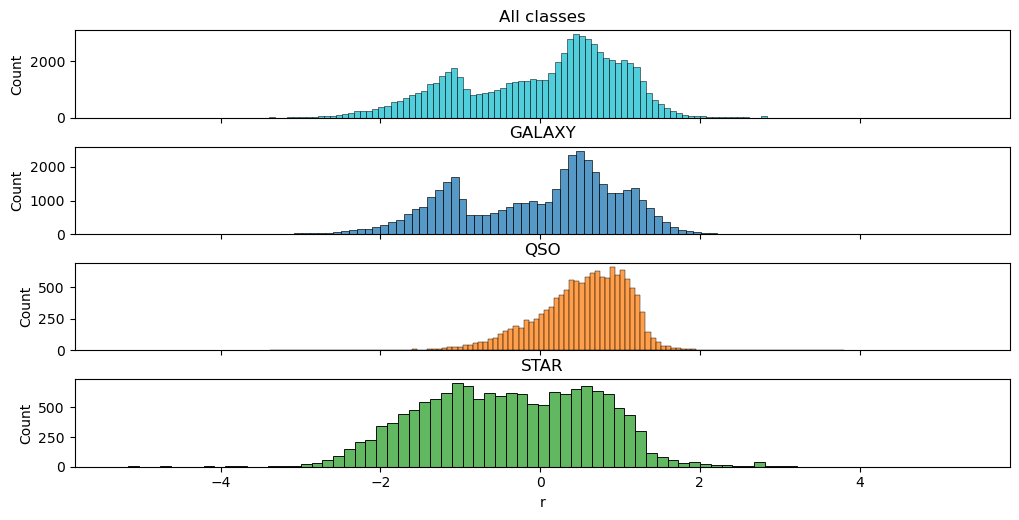

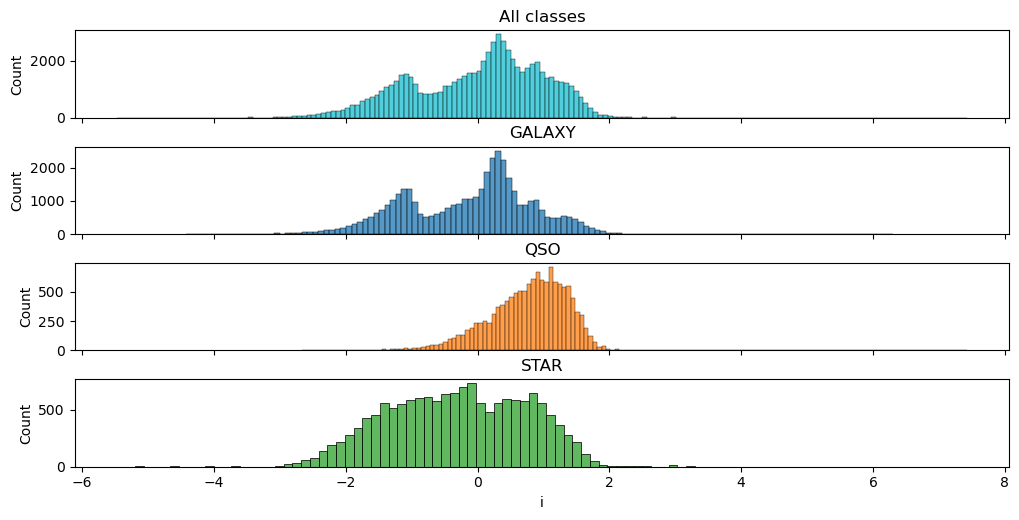

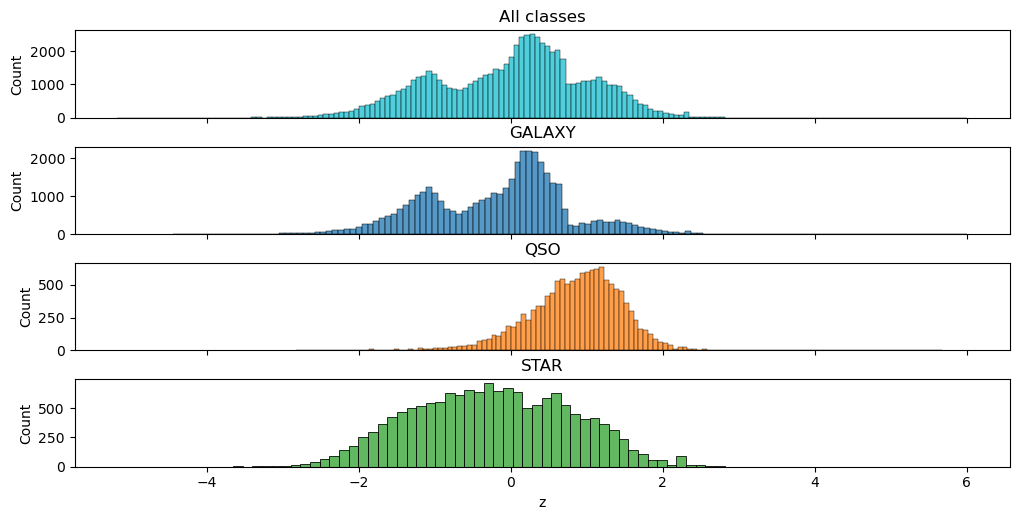

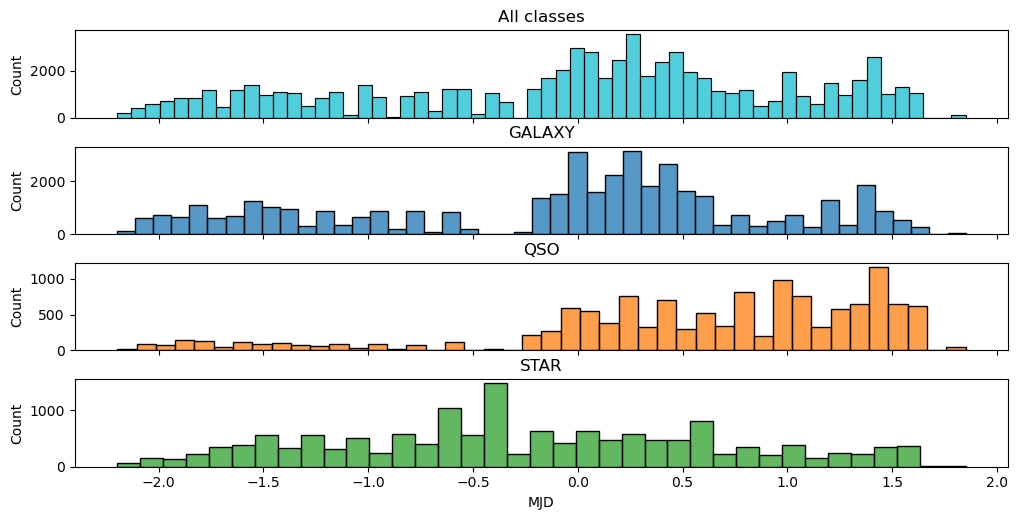

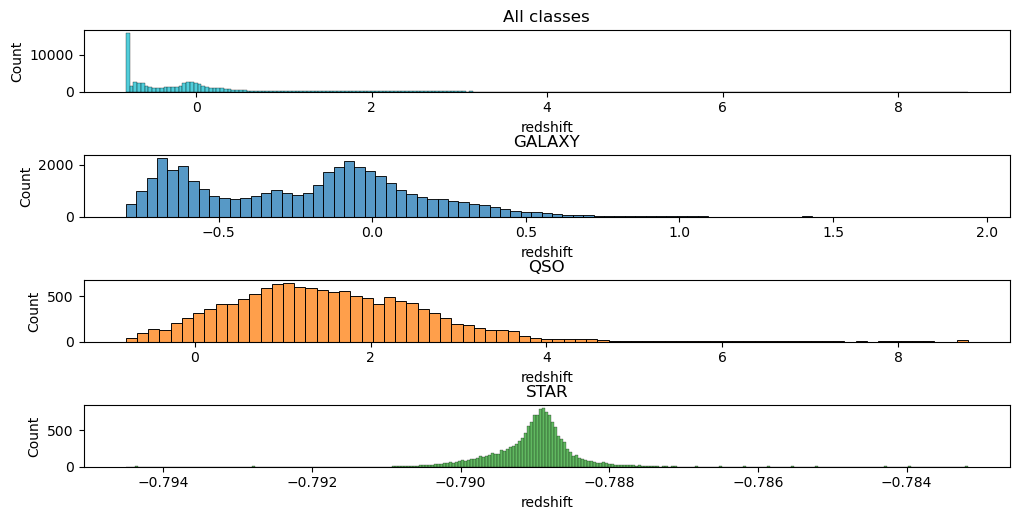

In [99]:
standard_distribution_info('u', True)
standard_distribution_info('g', True)
standard_distribution_info('r', True)
standard_distribution_info('i', True)
standard_distribution_info('z', True)
standard_distribution_info('MJD', True)
standard_distribution_info('redshift', False)

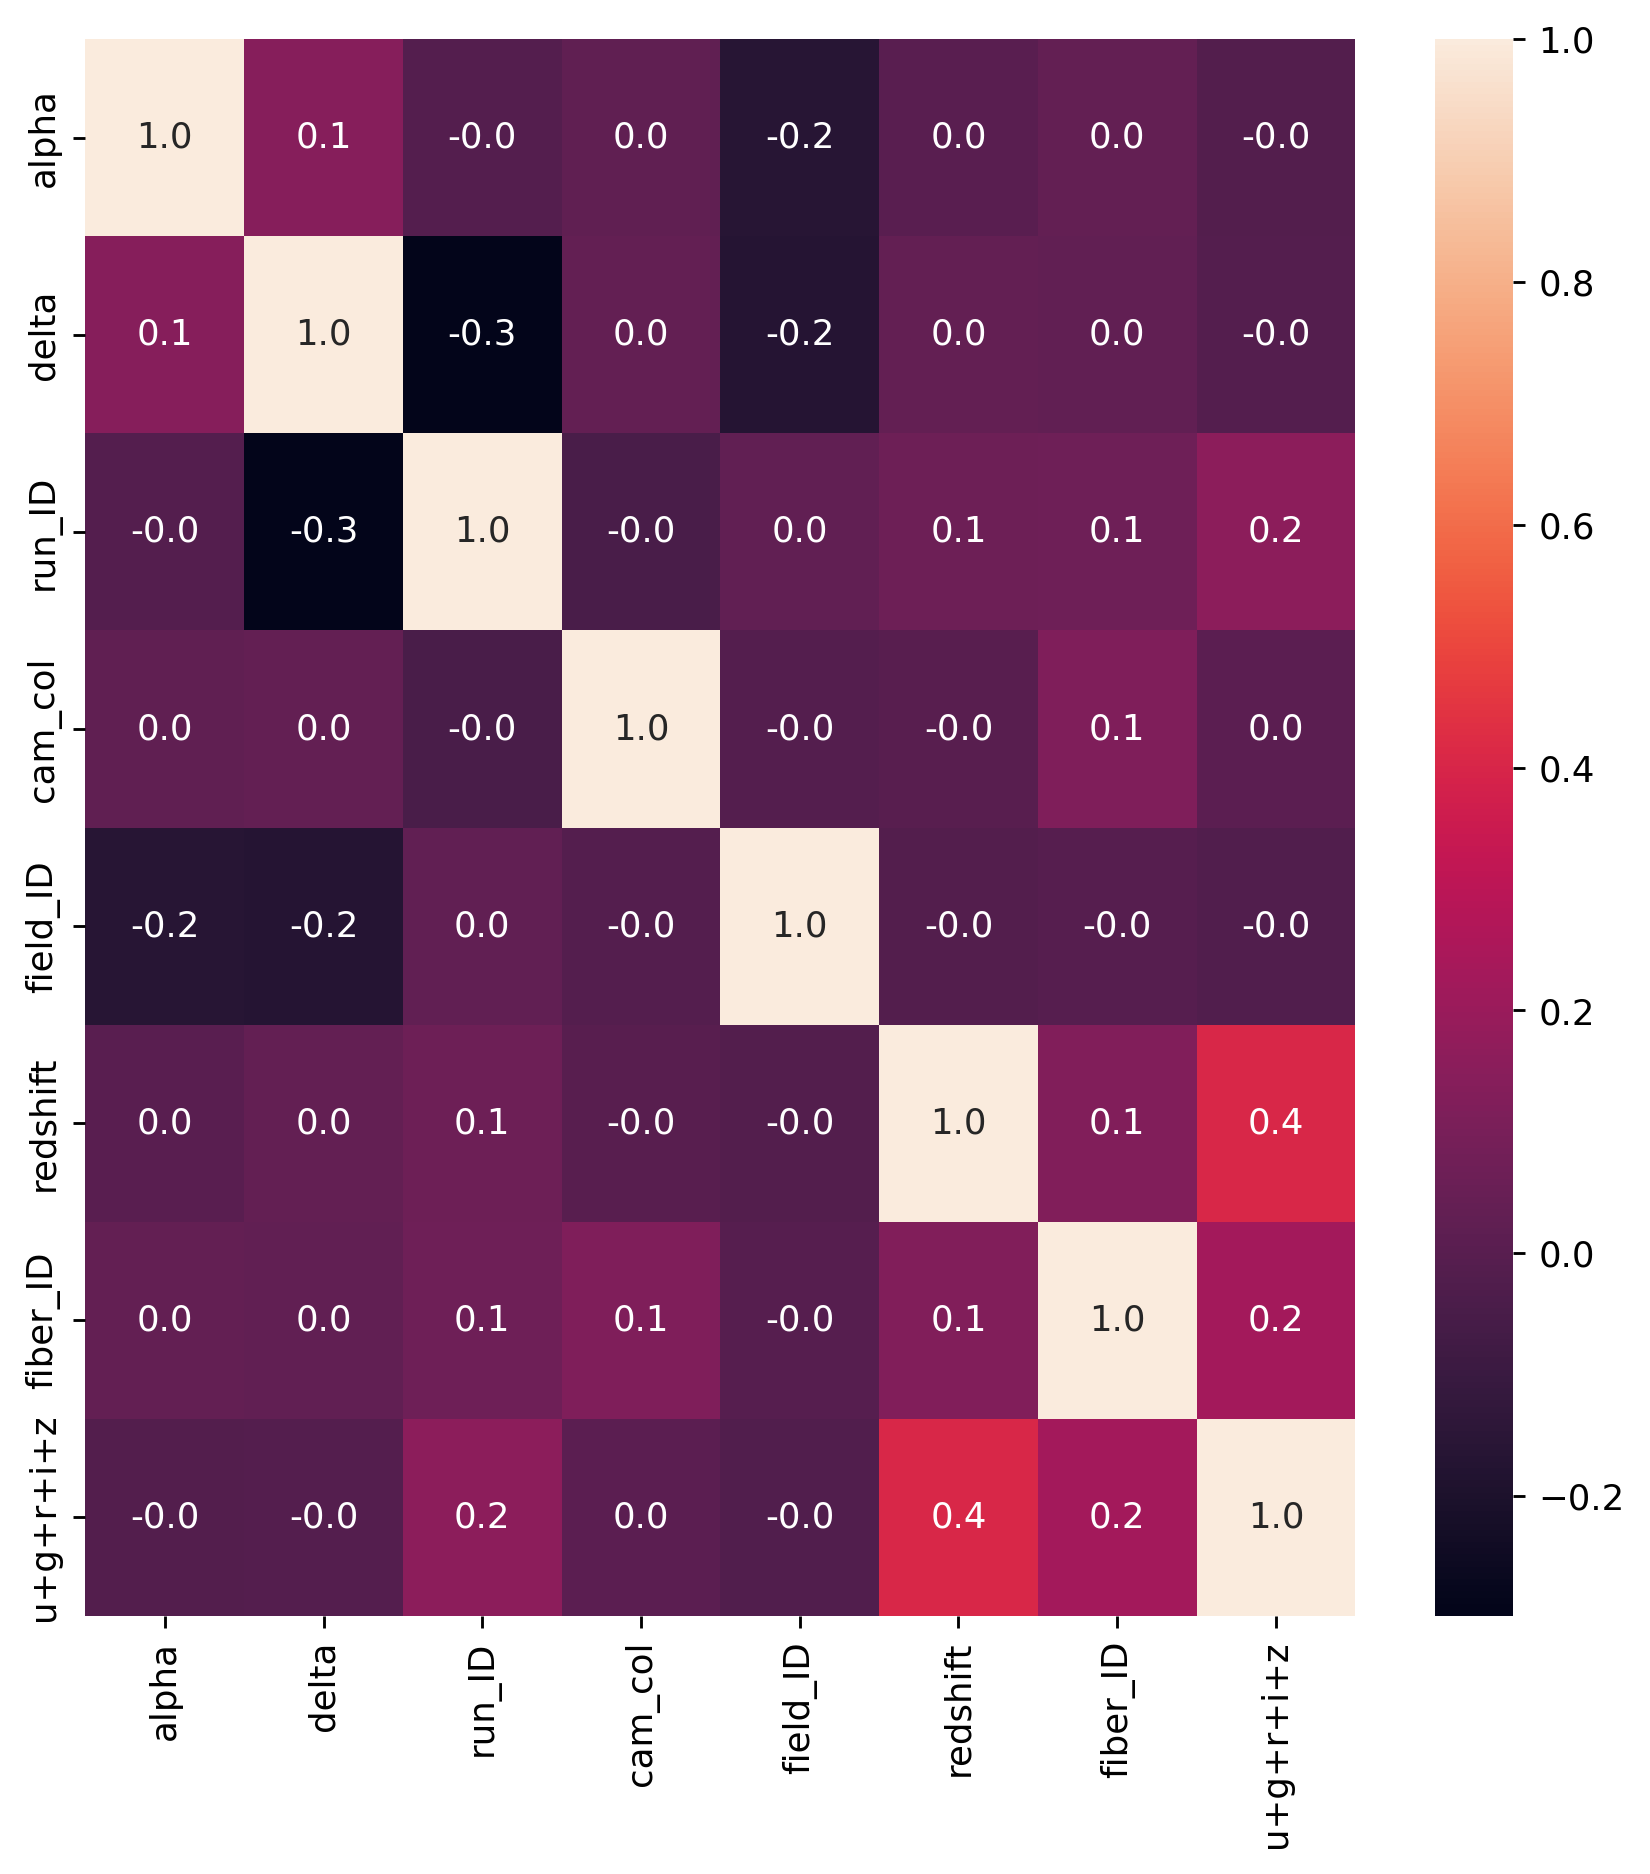

In [112]:
df_correlation = df.loc[:, df.columns != 'class'].corr()
fig = plt.figure(figsize=(8,8), dpi = 256)
sns.heatmap(df_correlation, annot = True, fmt = '.1f')
plt.show()

Testowanie

In [51]:
test_models(df)#zMJD i specobj

Dokładności modeli:
LogisticRegression 0.9567857142857142
KNeighborsClassifier: 0.9296428571428571
RandomForestClassifier: 0.9779285714285715
DecisionTreeClassifier: 0.9639285714285715
SVC: 0.9616428571428571


In [54]:
test_models(df)#zMJD

Dokładności modeli:
LogisticRegression 0.9550714285714286
KNeighborsClassifier: 0.93
RandomForestClassifier: 0.9779285714285715
DecisionTreeClassifier: 0.9629285714285715
SVC: 0.9601428571428572


In [57]:
test_models(df)#z specobj

Dokładności modeli:
LogisticRegression 0.9557142857142857
KNeighborsClassifier: 0.9243571428571429
RandomForestClassifier: 0.9771428571428571
DecisionTreeClassifier: 0.9639285714285715
SVC: 0.9614285714285714


In [104]:
test_models(df)#z sumami

Dokładności modeli:
LogisticRegression 0.9552142857142857
KNeighborsClassifier: 0.8997142857142857
RandomForestClassifier: 0.9785714285714285
DecisionTreeClassifier: 0.9622857142857143
SVC: 0.9602857142857143


In [110]:
test_models(df)#z sumą wszystkiego

Dokładności modeli:
LogisticRegression 0.9489285714285715
KNeighborsClassifier: 0.8829285714285714
RandomForestClassifier: 0.9697142857142858
DecisionTreeClassifier: 0.9471428571428572
SVC: 0.9532857142857143


In [113]:
test_models(df)#z sumą wszystkiego bez MJD

Dokładności modeli:
LogisticRegression 0.9483571428571429
KNeighborsClassifier: 0.8683571428571428
RandomForestClassifier: 0.9660714285714286
DecisionTreeClassifier: 0.9418571428571428
SVC: 0.9528571428571428


Wnioski